In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch

import os
# Set GPU ID
os.environ["CUDA_VISIBLE_DEVICES"]="2"
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu'
)

import deepinv as dinv
import ProxNest as pxn
from functools import partial


In [2]:


# Load Image
dim = 256
x_true = np.load('../../data/butterfly_{}.npy'.format(dim))

# Normalise magnitude
x_true -= np.nanmin(x_true)
x_true /= np.nanmax(x_true)
x_true[x_true<0] = 0

# To pytorch
x_true = torch.Tensor(x_true).to(device)
x = x_true.clone().to(device)


In [3]:
# Define noise parameters
ISNR = 20
sigma = np.sqrt(np.mean(np.abs(x_true.cpu().numpy())**2)) * 10**(-ISNR/20)

print('sigma*255: ', sigma*255)

# Define the forward operator
blur_kernel_size = 5

physics = dinv.physics.BlurFFT(
    img_size=(3, x.shape[-2], x.shape[-1]),
    filter=torch.ones(
        (1, 1, blur_kernel_size, blur_kernel_size),
        device=device
    ) / blur_kernel_size**2,
    device=device,
    noise_model=dinv.physics.GaussianNoise(sigma=sigma),
)

# Compute observations
y = physics(x)


sigma*255:  13.653015464544296


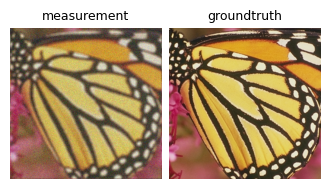

In [4]:
# Plot observations and true x

imgs = [y, x_true]
titles=["measurement", "groundtruth"]
dinv.utils.plotting.plot(
    imgs,
    titles=titles,
)

In [5]:

# Options dictionary associated with the overall sampling algorithm
options = {
    'samplesL': 1e1,        # Number of live samples
    'samplesD': 2e1,      # Number of discarded samples 
       'sigma': sigma,      # Noise standard deviation of degraded image
        'tol' : 1e-6,      # Convergence tolerance of algorithm (Ball projection alg)
   'max_iter' : 200,        # Maximum number of iterations (Ball projection alg)
    'verbose' : True,       # Verbosity
}

diff_params = {
             'model_type' : 'imagenet',     # Type of pretrained model. Options are 'imagenet' or 'ffhq'
            'in_channels' : 3,              # Channels in the input Tensor.
           'out_channels' : 3,              # Channels in the output Tensor.
            'sigma_noise' : sigma,          # Noise standard deviation of degraded image
        'diffusion_steps' : 100,            # Maximum number of iterations of the DiffPIR algorithm
                'lambda_' : 7.0,            # Regularisation parameter
                   'zeta' : 0.3,            # DiffPIR parameter controling the diffusion
         'reflection_pos' : 'end',    # Position to reflect. If "beggining", it is applied to x0 after the 
                                            # score is computed. If "end", it is applied at the last line of the 
                                            # reverse diffusion step.
    'reflection_strategy' : 1,              # Reflection strategy. `1` is using the prox projection to reflect, 
                                            # `2` reflects using the boundary's normal at the intersection, 
                                            # if `3` the reflection is done using the boundary's normal but 
                                            # from the point outside the boundary without computing the 
                                            # intersection with the boundary. 
}


# Gaussian log likelihood
LogLikeliL = lambda x_current, y, physics, sigma : - torch.nn.functional.mse_loss(
    y,
    physics.A(x_current), # Apply the forward model (without the noise addition)
    reduction='sum'
) / (2*sigma**2)

LikeliL = LogLikeliL

# Load the denoiser for the diffusion model 
if diff_params['model_type'] == 'imagenet':
    model_path = "/disk/xray99/tl3/pretrained_diffusions/diffpir_pretrained_models/256x256_diffusion_uncond.pt"
    large_model = True
elif diff_params['model_type'] == 'ffhq':
    model_path = "/disk/xray99/tl3/pretrained_diffusions/diffpir_pretrained_models/diffusion_ffhq_10m.pt"
    large_model = False

denoising_model = dinv.models.DiffUNet(
    in_channels=diff_params['in_channels'],
    out_channels=diff_params['out_channels'],
    pretrained=model_path,
    large_model=large_model
).to(device)


In [6]:

# Set initial state as current state
x_init = physics.A_adjoint(y)
Xcur = x_init
tau_0 = -LogLikeliL(Xcur, y, physics, sigma).cpu().numpy() * 2


# Build constrained prior sampler
constrained_prior_sampler = dinv.sampling.DiffPIR(
    denoising_model,
    sigma=diff_params['sigma_noise'],
    max_iter=diff_params['diffusion_steps'],
    lambda_=diff_params['lambda_'],
    zeta=diff_params['zeta'], # 0.5,
    data_fidelity=pxn.optimisations.l2_ball_proj.CustomIndicatorL2(
        radius=(np.sqrt(
            tau_0 * 2 * diff_params['sigma_noise']**2
        )),
        projection_type='deepinv',
        max_iter=200,
        stepsize=None,
        crit_conv=1e-10
    ),
    verbose=options['verbose'],
    device=device
)





In [7]:
x_constrained_a_1 = constrained_prior_sampler.forward(
    y, physics, x_init=(torch.randn_like(x_init)+1)/2
)


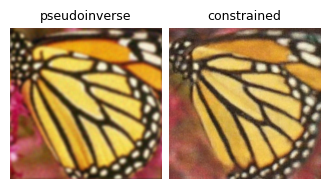

In [8]:

imgs = [x_init, x_constrained_a_1]
titles=["pseudoinverse", "constrained"]
dinv.utils.plotting.plot(
    imgs,
    titles=titles,
)



In [9]:


def l2_boundary_indicator(x, y, physics, radius):
    """L2 ball boundary indicator

    Returns `True` if x is inside the L2 ball.
    """
    l2_norm = torch.linalg.norm(y - physics.A(x))

    if l2_norm <= radius:
        return True
    else:
        return False






In [10]:

radius = np.sqrt(tau_0 * 2 * diff_params['sigma_noise']**2)

boundary_indicator = partial(l2_boundary_indicator, y=y, physics=physics, radius=radius)


reflected_diffpir = pxn.sampling.diffusion.ReflectedDiffPIR(
    denoising_model,
    sigma=diff_params['sigma_noise'],
    max_iter=diff_params['diffusion_steps'],
    lambda_=diff_params['lambda_'],
    zeta=diff_params['zeta'], # 0.5,
    boundary_indicator=boundary_indicator,
    data_fidelity=pxn.optimisations.l2_ball_proj.CustomIndicatorL2(
        radius=radius,
        projection_type='deepinv',
        max_iter=200,
        stepsize=None,
        crit_conv=1e-10
    ),
    diff_params=diff_params,
    verbose=options['verbose'],
    device=device
)




In [11]:


x_reflected = reflected_diffpir.forward(
    y, physics, x_init=(torch.randn_like(x_init)+1)/2
)


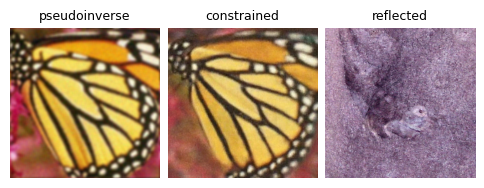

In [12]:

imgs = [x_init, x_constrained_a_1, x_reflected]
titles=["pseudoinverse", "constrained", "reflected"]
dinv.utils.plotting.plot(
    imgs,
    titles=titles,
)


In [13]:
radius

44.017234934176315

In [14]:
print('x_constrained_a_1: ', torch.linalg.norm(y - physics.A(x_constrained_a_1)))

print('x_reflected: ', torch.linalg.norm(y - physics.A(x_reflected)))


x_constrained_a_1:  tensor(44.0351, device='cuda:0')
x_reflected:  tensor(139.4696, device='cuda:0')
